In [ ]:
#| default_exp learner

These were directly copied from the corresponding notebook.

In [ ]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [ ]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
torch.set_printoptions(precision=2, linewidth=180, sci_mode=False)
torch.manual_seed(1103)
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
logging.disable(logging.WARNING)

# Learner

In [ ]:
x, y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(i)) for i in b[x]]
dst = ds.with_transform(transformi)

In [ ]:
#| export
class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[0], dls[1]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, num_workers=4):
        return cls(*[
            DataLoader(
                ds, batch_size=batch_size,
                collate_fn=collate_dict(ds), num_workers=num_workers
            ) for ds in dd.values()
        ])

In [ ]:
bs = 512
dls = DataLoaders.from_dd(dst, bs)
b = next(iter(dls.train))

In [ ]:
b[0].shape, b[1].shape

(torch.Size([512, 784]), torch.Size([512]))

In [ ]:
from miniai.training import accuracy

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func): fc.store_attr()

    def one_batch(self):
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()

    def calc_stats(self):
        n = self.xb.shape[0]
        self.losses.append(self.loss.item() * n)
        self.counts.append(n)
        self.accs.append(accuracy(self.preds, self.yb) * n)

    def one_epoch(self, train):
        self.model.training = train
        if train:
            dl = self.dls.valid
        else:
            dl = self.dls.train

        for self.batch_idx, self.batch in enumerate(dl):
            self.one_batch()
        count = sum(self.counts)
        stage = "train" if train else "valid"
        print(f"Epoch {self.epoch}, {stage}:  loss={sum(self.losses)/count:.4f}, accuracy={sum(self.accs)/count:.2f}")

    def fit(self, n_epochs):
        self.losses, self.counts, self.accs = [], [], []
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            self.one_epoch(False)
        

In [ ]:
b[0].shape

torch.Size([512, 784])

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10))

In [ ]:
learn = Learner(model, dls, F.cross_entropy, 0.1, torch.optim.SGD)

In [ ]:
learn.fit(2)

Epoch 0, train:  loss=1.9508, accuracy=0.46
Epoch 0, valid:  loss=1.5761, accuracy=0.57
Epoch 1, train:  loss=1.5374, accuracy=0.58
Epoch 1, valid:  loss=1.3353, accuracy=0.61


# Metrics

In [ ]:
#| export
class Metric:
    def __init__(self): self.reset()

    def reset(self):
        self.values = []
        self.counts = []

    def add(self, inp, targ=None, n=1):
        self.values.append(self.calc(inp, targ))
        self.counts.append(n)

    @property
    def value(self):
        return (torch.tensor(self.values) * torch.tensor(self.counts)).sum() / sum(self.counts)

    def calc(self, inp, targ):
        return inp

In [ ]:
#| export
class Accuracy(Metric):
    def calc(self, inp, targ):
        return (inp == targ).float().mean()

In [ ]:
acc = Accuracy()
acc.add(torch.tensor([2, 1, 1]), torch.tensor([1, 2, 2]), 3)
print(acc.value)
acc.add(torch.tensor([1, 2, 2, 1]), torch.tensor([1, 2, 2, 1]), 4)
acc.value, 4/7

tensor(0.)


(tensor(0.57), 0.5714285714285714)

In [ ]:
loss = Metric()
loss.add(0.1, n=100)
print(loss.value)
loss.add(1.1, n=900)
print(loss.value)

tensor(0.10)
tensor(1.)


# Callbacks Learner

In [ ]:
#| export
def identity(*args):
    return (*args,)

In [ ]:
identity()

()

In [ ]:
identity(1)

(1,)

In [ ]:
identity(1, 2)

(1, 2)

In [ ]:
identity([1,2])

([1, 2],)

In [ ]:
identity([1], (2,), {3:3}, 4)

([1], (2,), {3: 3}, 4)

In [ ]:
#| export
class CancelFitException(Exception): ...
class CancelBatchException(Exception): ...
class CancelEpochException(Exception): ...

In [ ]:
#| export
class with_cbs:
    def __init__(self, nm):
        self.nm = nm
        self.before = f"before_{nm}"
        self.after = f"after_{nm}"
        self.exception = f"Cancel{nm.title()}Exception"

    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(self.before)
                f(o, *args, **kwargs)
                o.callback(self.after)
            except globals()[self.exception]: ...
        return _f
                

In [ ]:
#|export
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func):
        fc.store_attr()
        for cb in cbs:
            cb.learn = self

    @with_cbs("batch")
    def one_batch(self):
        self.predict()
        self.get_loss()
        if self.model.training:
            self.backward()
            self.step()
            self.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        if train:
            self.dl = self.dls.valid
        else:
            self.dl = self.dls.train

        self._one_epoch()

    @with_cbs("epoch")
    def _one_epoch(self):
        for self.batch_idx, self.batch in enumerate(self.dl):
            self.one_batch()

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.range_epochs = range(self.n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self._fit()

    @with_cbs("fit")
    def _fit(self):
        for self.epoch in self.range_epochs:
            self.one_epoch(True)
            self.one_epoch(False)

    def __getattr__(self, name):
        if name in ("predict", "get_loss", "backward", "step", "zero_grad"):
            return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm):
        for cb in sorted(self.cbs, key=lambda x: x.order):
            getattr(cb, method_nm, identity)()

In [ ]:
#| export
class Callback:
    order = 0

In [ ]:
#| export
class TrainCB(Callback):
    def predict(self):
        self.learn.preds = self.learn.model(self.learn.batch[0])

    def get_loss(self):
        self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])

    def backward(self):
        self.learn.loss.backward()

    def step(self):
        self.learn.opt.step()

    def zero_grad(self):
        self.learn.opt.zero_grad()

In [ ]:
#|export
class DeviceCB(Callback):
    def before_fit(self):
        self.learn.model.to(def_device)
    def before_batch(self):
        self.learn.batch = to_device(self.learn.batch)

In [ ]:
#|export
class MetricsCB(Callback):
    def __init__(self, metric=None):
        self.loss = Metric()
        self.metrics = [self.loss]
        self.metric = metric
        if metric is not None:
            self.metrics.append(self.metric)

    def log(self, *s):
        stage = "train" if self.learn.model.training else "valid"
        print(f"Epoch {self.learn.epoch}, {stage}:", *s) 

    def before_fit(self): self.learn.metrics = self

    def before_epoch(self):
        for m in self.metrics:
            m.reset()

    def after_epoch(self):
        self.log(*[f"{m.value:.3f}" for m in self.metrics])

    def after_batch(self):
        if self.metric:
            self.metric.add(self.learn.preds.argmax(dim=1), self.learn.batch[1])
        self.loss.add(self.learn.loss, n=self.learn.batch[1].shape[0])

In [ ]:
progress_bar?

Init signature:
progress_bar(
    gen,
    total=None,
    display=True,
    leave=True,
    parent=None,
    master=None,
    comment='',
)
Docstring:      <no docstring>
File:           ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastprogress/fastprogress.py
Type:           type
Subclasses:     

In [ ]:
print(list(filter(lambda x: x[0]!='_', dir(progress_bar))))

['first_its', 'lt', 'on_interrupt', 'on_iter_begin', 'on_iter_end', 'on_update', 'update', 'update_bar', 'update_every']


In [ ]:
master_bar?

Init signature:
master_bar(
    gen,
    total=None,
    hide_graph=False,
    order=None,
    clean_on_interrupt=False,
    total_time=False,
)
Docstring:      <no docstring>
File:           ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastprogress/fastprogress.py
Type:           type
Subclasses:     

In [ ]:
print(list(filter(lambda x: x[0]!='_', dir(master_bar))))

['add_child', 'first_its', 'lt', 'names', 'on_interrupt', 'on_iter_begin', 'on_iter_end', 'on_update', 'show', 'show_imgs', 'update', 'update_bar', 'update_every', 'update_graph', 'write']


In [ ]:
master_bar.update_graph?

Signature:
master_bar.update_graph(
    self,
    graphs,
    x_bounds=None,
    y_bounds=None,
    figsize=(6, 4),
)
Docstring: <no docstring>
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastprogress/fastprogress.py
Type:      function

In [ ]:
#|export
class ProgressCB(Callback):
    def __init__(self, plot=False): self.plot=plot

    def before_fit(self):
        self.learn.range_epochs = master_bar(self.learn.range_epochs)
        self.mb = self.learn.range_epochs
        if hasattr(self.learn, "metrics"):
            self.learn.metrics.log = self.log
        self.losses = []

    def log(self, *s):
        self.mb.write(", ".join(s))

    def before_epoch(self):
        self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mb)

    def after_batch(self):
        self.learn.dl.comment = f"{self.learn.loss:.4f}"
        if self.plot and hasattr(self.learn, "metrics") and self.learn.model.training:
            self.losses.append(self.learn.loss.item())
            self.mb.update_graph([
                [list(range(len(self.losses))), self.losses]
            ])
        
    

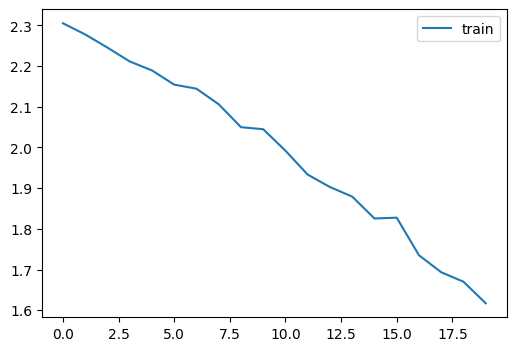

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10))
cbs = [TrainCB(), DeviceCB(), MetricsCB(metric=Accuracy()), ProgressCB(True)]
learn = Learner(model, dls, F.cross_entropy, 0.1, cbs, torch.optim.SGD)
learn.fit(1)

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()